In [3]:
import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'animal-detection-small-dataset:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F37898%2F57718%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240303%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240303T184111Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D9df21684b0ced7117d7ddf8607c1c04d326d5eb483b57475c97e04ca2bf9e84e1af0598d878605e189633c424b53aeb5fd674071763dc1de52bdee02927117d75c1903244ce1e63783b35618a4ca8e9dd6687bdcadfefeb11ffb886f792f095f25d25d4a5ea2143789353f410e7012aebad2a7897d72573e27d791713414c83f144e047a35a660e79559708c63f72af0946f66526cf2fd11a5451dffc784dc2dda0c14e4303b540f9102dd832ac58487608e5af442a381633492771419f12cc70ddb6059c3fcd32bd9021036e6e30890b65c32fe81df3867ded538078b6e3bcf7340ccce3f4681cd0acb76019edc4863635b0d44011af4ab6df50e9f4957af0d,animal-classification:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F616920%2F1102439%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240303%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240303T184111Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D07feecc44831af1910982700bb7e553b3cdec97bb57c639b53595527971609d8b9ab2d192fabbe5b5c163417161435e90a4156e92f80be0358dca49a2ca1f4c5c83bf9c59b9849a6831df681690f0e673307fdc0e84489cd1877dcaf4ee6c192d337929c97674dbf41839affeaed40a4c84c8006055e2841cfa6362deb22541e97ec1f6526c04c5cb406e5eb75d76ccb77981666871543ea98bbd6cc545e75ed18f127bd7d8db140fa5992add1456b9725f60a0a293d2674a9c260fb687b60f763c2538a4c3f19f942f55094bb123e802b18edd1d185ac899cc63a4e2935c227fff3f99adce0968b1805b459f89faacc921d9679c29744c5eb17ca33d6c0a3db,african-wildlife:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F674157%2F1185810%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240303%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240303T184111Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D8fcd384383afc5466df54f6dc3c07a8f10b800ab9f8e730a95b31f3686cc4b29d02461bb27128e03a979c7a28d7f81283a84598fee4708c9c37179ba469369dacf80233658d7eb7e45a40e62bd5ccd819703de3c08da31c787cf83abae8543b0456ccde03733180fac8ef8441ba40434ea22e0fc4c80fab47d187636ee44d1bce9dfa29373ab96650e0de1e629b9774fc94b72f97f67262797b331696cf96d9991828cc3a14f9f2385cadd9fad1bf8ad23a2ac3b51e9cbe4043ee714c64e61529ff77141841bfa9a7fe216dbea3cd2b0c7de6e91558c9c244eb4cfc0114d4830038e1c6baabb4cea20b56e488d9f970dcfcebaf48d0b3288c8ebc1de19f1293a,cheetahtigerwolf:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F731756%2F1270998%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240303%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240303T184111Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D3e30db30c22ee7461e80f285ada6144006a46a7b45339de063ff32e50a862d7a517a03ec619f829377cc7372402921607b40f35002c9f9d1c46ae7d601cf9a6f73bef4bddec05a48b1235f2c33f3bcdea44b7e62faa9914e58d1f870295edf905ce06de78af2116d3ae07d2f819140e36c621dd82abbf8c734f515f9cfa13a30af1af5930023adfe2ea62c780d65d1c673a7b78232602d180968425fbc17cd1e23ddb1d654b57fcfe889e890e1c6f1a0e6dc65f8299336d6c87a345f115bbd9c344b4e8cd42cf9c412a31206c8f376ce1033da5213eca1f022c88ce5d401c2e015c76f6a349e645407b117fbd861899a1f7b21137f31d4347928a4fd4386ef95'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 6874991755 bytes downloaded
Downloaded and uncompressed: animal-detection-small-dataset
[==================================================] 434445864 bytes downloaded
Downloaded and uncompressed: animal-classification
[==================================================] 469442673 bytes downloaded
Downloaded and uncompressed: african-wildlife
[==================================================] 2692178008 bytes downloaded
Downloaded and uncompressed: cheetahtigerwolf
Data source import complete.


Importing Libraries

In [4]:
import keras
import os
import shutil
import numpy as np
import math
import random
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from platform import python_version

print('Python version:', python_version())
print('Numpy version:', np.__version__)
print('Seaborn version:', sns.__version__)
from distutils.dir_util import copy_tree
import tensorflow as tf
print('tensorflow version: ',tf.__version__)
print('keras version:', keras.__version__)

Python version: 3.10.12
Numpy version: 1.25.2
Seaborn version: 0.13.1
tensorflow version:  2.15.0
keras version: 2.15.0


In [5]:
!pip install keras_preprocessing
from keras.layers import Convolution2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.models import Sequential
from keras.layers import Dropout
from keras_preprocessing.image import ImageDataGenerator


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 1.7 MB/s eta 0:00:00


  Dataset Creation

In [6]:
#created data set using console
source='../input/african-wildlife/'
target='./train_data/'
shutil.copytree(source, target)
os.mkdir('test_data')

In [7]:
# remove unwanted data and create same classed for test_data

path="./train_data/"
for file in os.listdir(path):
    for image in os.listdir(path+file+'/'):
        if '.jpg' not in image:
            os.remove(path+file+'/'+image)
    os.mkdir('./test_data/'+file)


In [8]:
# create test_data by taking 25% images from data

total_train_images,total_test_images,total_train_classes,total_test_classes=0,0,0,0
path="./train_data/"
for file in os.listdir(path):
    total_train_classes+=1
    total_images=len(os.listdir(path+file+"/"))
    test_image_count=(25/100)*total_images #25% for test and 75% for train
    for i in range(math.ceil(test_image_count)):
        img=random.choice(os.listdir(path+file+'/'))
        shutil.move(path+file+'/'+img,'./test_data/'+file+'/')
        #print(img)
    print(file,total_images,math.ceil(test_image_count))
    total_train_images+=(total_images-math.ceil(test_image_count))
    #print(file,math.ceil(test_image_count))
print("total train images are : ",total_train_images," and total train classes are : ",total_train_classes)

elephant 375 94
zebra 376 94
buffalo 375 94
rhino 375 94
total train images are :  1125  and total train classes are :  4


Model Creation

In [9]:
model = Sequential()

In [10]:
#inputlayer : apply filters
model.add(Convolution2D(filters=32,
                        kernel_size=(3,3),
                        strides=(1,1),
                        padding='same',
                        activation='relu',
                   input_shape=(32, 32, 1)))

In [11]:
# pooling layer where we are doing maxpooling
model.add(MaxPooling2D(pool_size=(2, 2)))

In [12]:
#adding one more convolution layer for better model
model.add(Convolution2D(filters=32,
                        kernel_size=(3,3),
                        strides=(1,1),
                        padding='same',
                        activation='relu'
                      ))

In [13]:
#adding one more Pooling layer for better model
model.add(MaxPooling2D(pool_size=(2, 2)))

In [14]:
#dropout regularlization
model.add(Dropout(0.5))

In [15]:
#layer in which we are converting 2d/3d image to 1d image i.e flattening
model.add(Flatten())

In [16]:
# layer: appling relu to give positive output from here our hidden layerrs starts
model.add(Dense(units=20, activation='relu'))

In [17]:
#dropout regularlization
model.add(Dropout(0.5))

In [18]:
# output layer : Since we have to do multi-class classification so we'll apply softmax activation function
# we have 4 classes of animals so output layer would have that many neurons.
model.add(Dense(units=4, activation='softmax'))

In [19]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 16, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 8, 8, 32)          0         
 g2D)                                                            
                                                                 
 dropout (Dropout)           (None, 8, 8, 32)          0         
                                                                 
 flatten (Flatten)           (None, 2048)              0

Image Augmentation

In [21]:
#url : https://keras.io/api/preprocessing/image/
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)
training_set = train_datagen.flow_from_directory(
        './train_data/',
        target_size=(32,32),
        color_mode="grayscale",
        batch_size=64,
        class_mode='categorical')
test_set = test_datagen.flow_from_directory(
        './test_data/',
        target_size=(32,32),
        color_mode="grayscale",
        batch_size=64,
        class_mode='categorical')

Found 1125 images belonging to 4 classes.
Found 376 images belonging to 4 classes.


In [22]:
training_set.class_indices # to see classes of our dataset

{'buffalo': 0, 'elephant': 1, 'rhino': 2, 'zebra': 3}

In [23]:
history = model.fit(
        training_set,
        steps_per_epoch=(1125/64),
        epochs=100,
        validation_data=test_set,
        validation_steps=(376/64))

Epoch 1/100
17/17 [==============================] - 24s 1s/step - loss: 1.3946 - accuracy: 0.2622 - val_loss: 1.3863 - val_accuracy: 0.2553
Epoch 2/100
17/17 [==============================] - 19s 1s/step - loss: 1.3866 - accuracy: 0.2516 - val_loss: 1.3858 - val_accuracy: 0.2500
Epoch 3/100
17/17 [==============================] - 19s 1s/step - loss: 1.3861 - accuracy: 0.2578 - val_loss: 1.3813 - val_accuracy: 0.3564
Epoch 4/100
17/17 [==============================] - 19s 1s/step - loss: 1.3829 - accuracy: 0.2693 - val_loss: 1.3725 - val_accuracy: 0.3511
Epoch 5/100
17/17 [==============================] - 19s 1s/step - loss: 1.3825 - accuracy: 0.2720 - val_loss: 1.3726 - val_accuracy: 0.3697
Epoch 6/100
17/17 [==============================] - 19s 1s/step - loss: 1.3685 - accuracy: 0.2916 - val_loss: 1.3418 - val_accuracy: 0.3723
Epoch 7/100
17/17 [==============================] - 20s 1s/step - loss: 1.3567 - accuracy: 0.3031 - val_loss: 1.3038 - val_accuracy: 0.3830
Epoch 8/100
1

graph

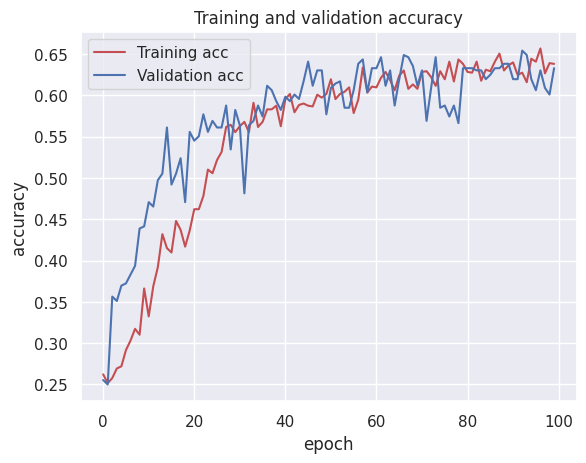

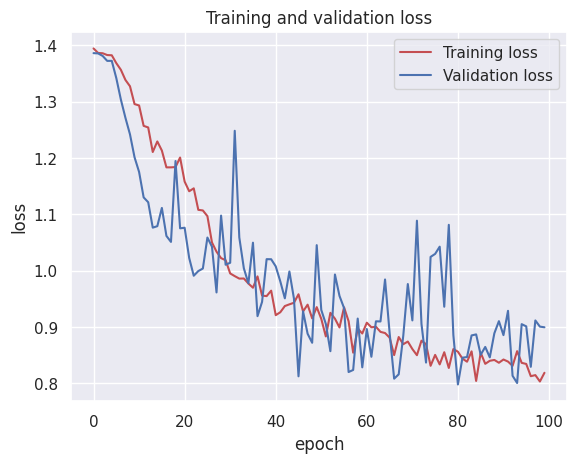

In [24]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'r', label='Training acc')
plt.plot(epochs, val_accuracy, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.show()

In [25]:
model.save("simple_animal_classification_model.h5")#save model

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [26]:
from keras.models import load_model
model=load_model("simple_animal_classification_model.h5")

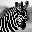

In [27]:
from keras.preprocessing import image
test_image = image.load_img("/content/gettyimages-124027475-612x612.jpg",target_size=(32,32),color_mode='grayscale')
test_image


In [28]:
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image,axis=0)

In [29]:
result = model.predict(test_image)

my_dict=training_set.class_indices
def get_key(val):
    for key, value in my_dict.items():
         if val == value:
             return key

    return "key doesn't exist"

pred=list(result[0])
for i in range(len(pred)):
    if pred[i]!=0:
        print(get_key(i))

1/1 [==============================] - 0s 127ms/step
zebra
